## Mapping Richmond's Sewer System

Data from ArcGIS user DOEE_GIS
* https://www.arcgis.com/home/search.html?q=owner%3A%22DOEE_GIS%22&t=content&restrict=false


In [2]:
import json
import pandas as pd
import requests
from arcgis2geojson import arcgis2geojson
import geopandas as gpd

import os


In [3]:
# Set up the parameters

# Endpoints
urls = {'cso_boundaries': 'https://services1.arcgis.com/8eq00iyMv7Ls2xme/ArcGIS/rest/services/Richmond_CSO_Boundary_Delineation/FeatureServer/0/query', 
        'ss_gravity': 'https://services1.arcgis.com/8eq00iyMv7Ls2xme/ArcGIS/rest/services/Sewer_System_Gravity_Pipe/FeatureServer/0/query',
        'storm_sewer': 'https://services1.arcgis.com/8eq00iyMv7Ls2xme/ArcGIS/rest/services/Storm_System_Pipe/FeatureServer/0/query'
       }

params = dict(
    f='json',
    where='1=1',
    returnGeometry='true',
    spatialRel='esriSpatialRelIntersects',
    geometryType='esriGeometryEnvelope',
    inSR=None,
    outFields='*',
    orderByFields=None,
    outSR=None,
    resultOffset=0,
    resultRecordCount=10
)


In [7]:
import requests
import json
import pandas as pd
import math
import geopandas as gpd
from arcgis2geojson import arcgis2geojson
from io import StringIO 

def get_arcgisjson(url, params):
    print(f"URL: {url}")
    # find max row count
    max_count_params = dict(
        f='json',
        where='1=1',
        returnIdsOnly='true' # special query param, returns ALL (no limit) OBJECTIDs (or whatever the ID column is)
    )
    resp = requests.get(url=url, params=max_count_params)
    ids = resp.json() 
    # total count of objectIds
    rowcount = len(ids['objectIds'])
    pages = math.ceil(rowcount / 1000) 
    print(f"{rowcount} total items, {pages} pages to get")
    # load all the data
    # use a json obj, no df needed
    jo = {}
    pagelen = 1000
    params['resultRecordCount'] = pagelen
    for i in range(0,pages): # set this to 1 or 2 for testing
        params['resultOffset'] = i*pagelen
        #print(f"Request {str(i)}: {params['resultOffset']}")
        print('.', end='', flush=True)
        resp = requests.get(url=url, params=params)
        data = resp.json() 
        print('-', end='', flush=True)
        # JSON processing
        if i==0:
            jo = data
        else:
            jo['features'] = jo['features'] + data['features']
    # convert ESRI json to geoJSON
    gjo = arcgis2geojson(jo)
    # get crs (coordinate reference system) from response
    wkid = jo['spatialReference']['latestWkid']
    gjo['wkid'] = wkid
    return gjo

def arcgisjson_to_gdf(filename, wkid=3857, out_crs=2284):
    # read GeoJSON into GeoPandas
    gdf = gpd.read_file(filename) 
    gdf.crs = wkid # see https://github.com/geopandas/geopandas/issues/1449 - arcgis2geojson is not correctly transforming the CRS to GeoJSON default
    gdf = gdf.to_crs(out_crs) 
    return gdf

In [8]:
out_crs = 2284 # commonly used with Richmond GIS data?

In [9]:
if not os.path.isfile('data/cso_boundaries.json'):
    csob_json = get_arcgisjson(urls['cso_boundaries'], params)
    with open('data/cso_boundaries.json', 'w') as fp:
        json.dump(csob_json, fp)

csob = arcgisjson_to_gdf('data/cso_boundaries.json', wkid=3857, out_crs=out_crs)

In [10]:
if not os.path.isfile('data/ss_gravity.json'):
    ssg_json = get_arcgisjson(urls['ss_gravity'], params)
    for r in ssg_json['features']:
        # the GlobalID contains curly braces which Fiona complains about in JSON
        r['properties']['GlobalID'] = r['properties']['GlobalID'].replace("{","").replace("}","")
    print(f"WKID:{ssg_json['wkid']}")
    with open('data/ss_gravity.json', 'w') as fp:
        json.dump(ssg_json, fp)

ss_gravity = arcgisjson_to_gdf('data/ss_gravity.json', wkid=3857, out_crs=out_crs)

In [12]:
if not os.path.isfile('data/storm_sewer.json'):
    ss_json = get_arcgisjson(urls['storm_sewer'], params)
    for r in ss_json['features']:
        # the GlobalID contains curly braces which Fiona complains about in JSON
        r['properties']['GlobalID'] = r['properties']['GlobalID'].replace("{","").replace("}","")
    wkid=ss_json['wkid']
    print(f"WKID:{wkid}")
    with open('data/storm_sewer.json', 'w') as fp:
        json.dump(ss_json, fp)

storm_sewer = arcgisjson_to_gdf('data/storm_sewer.json', wkid=3857, out_crs=out_crs)

In [ ]:
# Save resources to shapefiles for portability
csob.to_file(driver = 'ESRI Shapefile', filename="shapefile/richmond_cso_boundaries.shp")
ss_gravity.to_file(driver = 'ESRI Shapefile', filename="shapefile/richmond_sewer_gravity_pipes.shp")


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

In [13]:
storm_sewer.to_file(driver = 'ESRI Shapefile', filename="shapefile/richmond_storm_sewers.shp")

## Plotting

In [19]:
# for the background (base layer), I'm just loading the road shapes. there's a bunch of other options
# From Richmond GIS FTP - ftp://ftp.ci.richmond.va.us/GIS/Shapefiles/Basemap/
rvaroads = gpd.read_file('Basemap/base_Road.shp')
rvastreams = gpd.read_file('Basemap/base_StreamPolygon.shp')
rvalakes = gpd.read_file('Basemap/base_LakePolygon.shp')

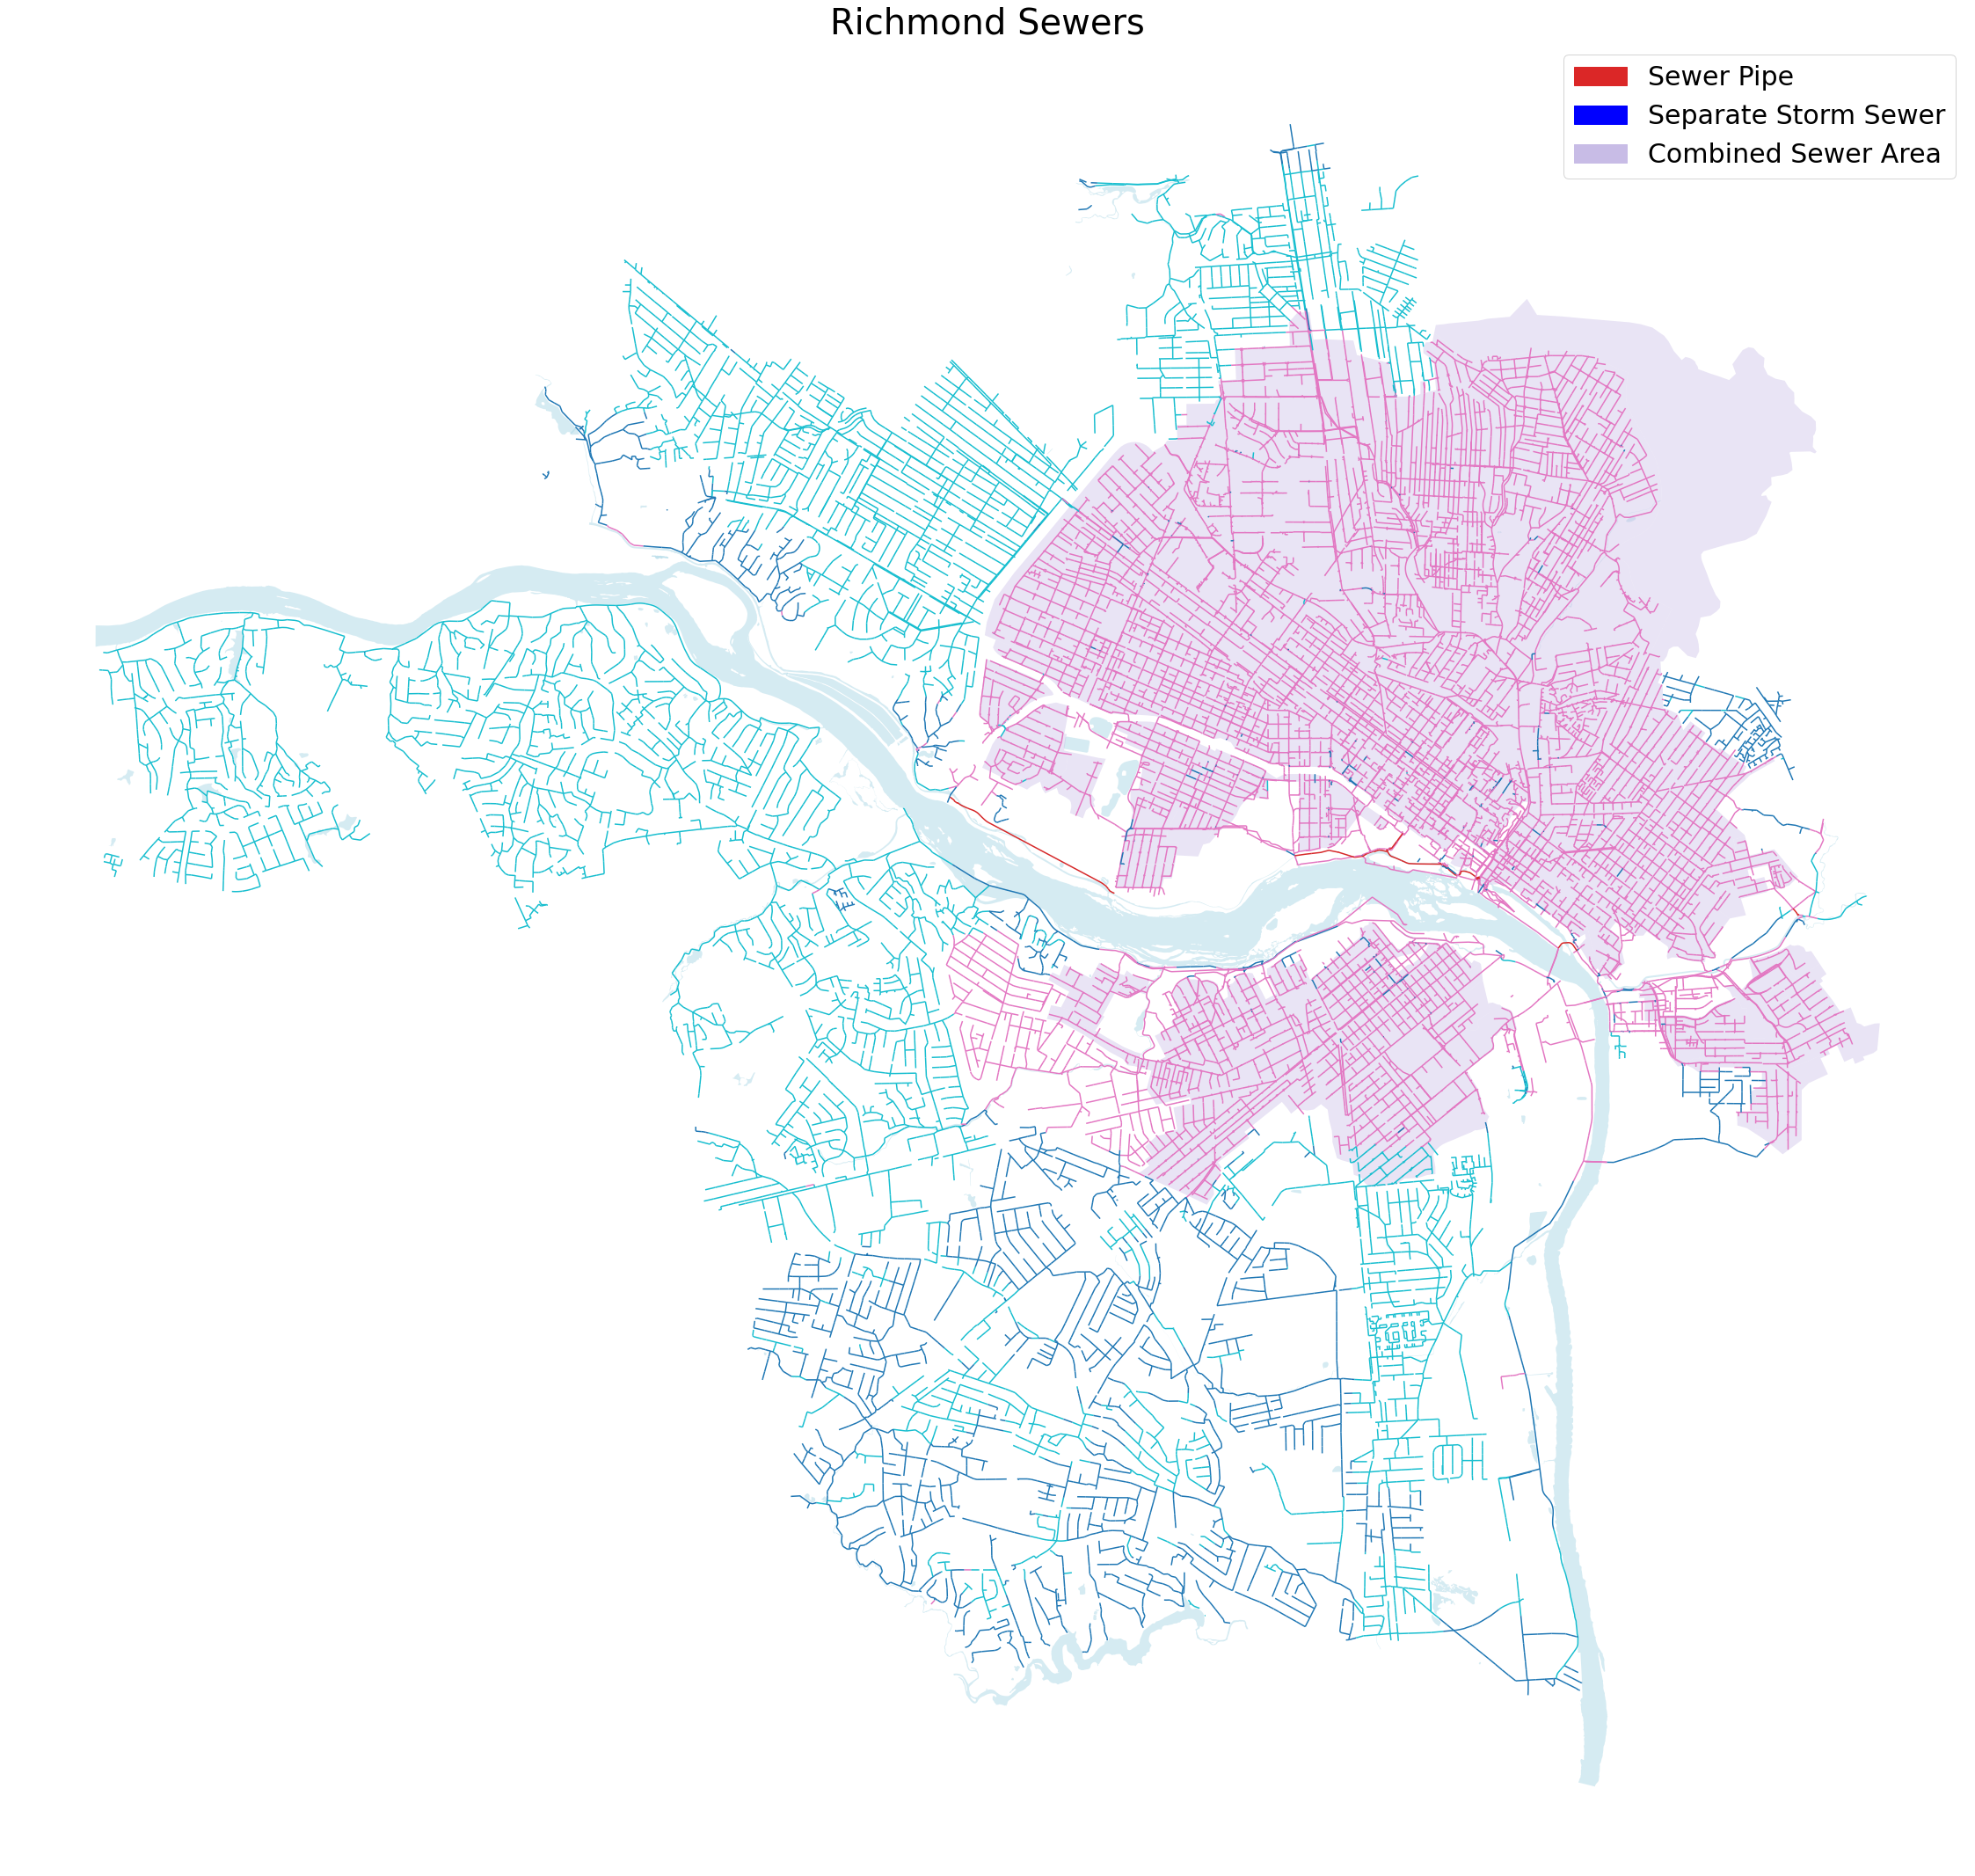

<Figure size 432x288 with 0 Axes>

In [40]:
from matplotlib import pyplot as plt
# let's do some plottttts
fig = plt.figure(figsize=(40,40)) # controls resolution - figure size in inches
ax = fig.add_subplot()

# plot a base layer
#rvaroads.plot(ax=ax, color='white', edgecolor='#999999')
rvastreams.plot(ax=ax, color="#add8e6", alpha=0.5)
rvalakes.plot(ax=ax, color="#add8e6", alpha=0.5)

csob.plot(color="#c8bce6", ax=ax, alpha=0.4) # was "Layer",
#ss_gravity.plot(ax=ax, color="#db2727")
ss_gravity.plot("System", ax=ax, legend=True)
#storm_sewer.plot(ax=ax, color="blue")

ax.set_title('Richmond Sewers', fontsize=40)

# manual legend
import matplotlib.patches as mpatches
sewer = mpatches.Patch(color='#db2727', label='Sewer Pipe')
storm = mpatches.Patch(color='blue', label='Separate Storm Sewer')
cso = mpatches.Patch(color='#c8bce6', label='Combined Sewer Area')
plt.legend(handles=[sewer, storm, cso], fontsize=30)

plt.axis('off')

plt.show(fig)
plt.savefig("pics/sewers.png", facecolor='white', bbox_inches='tight')

In [24]:
csob

FID   Layer                                            DocPath  \
0     1     006  D:\PROJECTS\Richmond Bacteria TMDL\CSO Boundar...   
1     2     007  D:\PROJECTS\Richmond Bacteria TMDL\CSO Boundar...   
2     3     018  D:\PROJECTS\Richmond Bacteria TMDL\CSO Boundar...   
3     4   020-1  D:\PROJECTS\Richmond Bacteria TMDL\CSO Boundar...   
4     5   008-1  D:\PROJECTS\Richmond Bacteria TMDL\CSO Boundar...   
5     6   010-2  D:\PROJECTS\Richmond Bacteria TMDL\CSO Boundar...   
6     7   011-1  D:\PROJECTS\Richmond Bacteria TMDL\CSO Boundar...   
7     8  019B-1  D:\PROJECTS\Richmond Bacteria TMDL\CSO Boundar...   
8     9   008-2  D:\PROJECTS\Richmond Bacteria TMDL\CSO Boundar...   
9    10   011-2  D:\PROJECTS\Richmond Bacteria TMDL\CSO Boundar...   
10   11   010-1  D:\PROJECTS\Richmond Bacteria TMDL\CSO Boundar...   
11   12    019A  D:\PROJECTS\Richmond Bacteria TMDL\CSO Boundar...   
12   13  019B-2  D:\PROJECTS\Richmond Bacteria TMDL\CSO Boundar...   
13   14  019B-S  D:\PROJECTS\Richmond Bacteria TMDL\CSO Boundar...   
14   15   020-3  D:\PROJECTS\Richmond Bacteria TMDL\CSO Boundar...   
15   16   020-2  D:\PROJECTS\Richmond Bacteria TMDL\CSO Boundar...   
16   17   017-1  D:\PROJECTS\Richmond Bacteria TMDL\CSO Boundar...   
17   18   017-2  D:\PROJECTS\Richmond Bacteria TMDL\CSO Boundar...   
18   19     036  D:\PROJECTS\Richmond Bacteria TMDL\CSO Boundar...   
19   20     009  D:\PROJECTS\Richmond Bacteria TMDL\CSO Boundar...   
20   21    028B  D:\PROJECTS\Richmond Bacteria TMDL\CSO Boundar...   
21   22    028C  D:\PROJECTS\Richmond Bacteria TMDL\CSO Boundar...   
22   23    028D  D:\PROJECTS\Richmond Bacteria TMDL\CSO Boundar...   
23   24  019B-3  D:\PROJECTS\Richmond Bacteria TMDL\CSO Boundar...   
24   25     012  D:\PROJECTS\Richmond Bacteria TMDL\CSO Boundar...   
25   26    028A  D:\PROJECTS\Richmond Bacteria TMDL\CSO Boundar...   
26   27    028E  D:\PROJECTS\Richmond Bacteria TMDL\CSO Boundar...   
27   28    035A  D:\PROJECTS\Richmond Bacteria TMDL\CSO Boundar...   
28   29     034  D:\PROJECTS\Richmond Bacteria TMDL\CSO Boundar...   
29   30     039  D:\PROJECTS\Richmond Bacteria TMDL\CSO Boundar...   
30   31     004  D:\PROJECTS\Richmond Bacteria TMDL\CSO Boundar...   
31   32     005  D:\PROJECTS\Richmond Bacteria TMDL\CSO Boundar...   
32   33     016  D:\PROJECTS\Richmond Bacteria TMDL\CSO Boundar...   
33   34  035B-S  D:\PROJECTS\Richmond Bacteria TMDL\CSO Boundar...   
34   35   006-S  D:\PROJECTS\Richmond Bacteria TMDL\CSO Boundar...   
35   36     021  D:\PROJECTS\Richmond Bacteria TMDL\CSO Boundar...   
36   37     015  D:\PROJECTS\Richmond Bacteria TMDL\CSO Boundar...   
37   38   014-S  D:\PROJECTS\Richmond Bacteria TMDL\CSO Boundar...   
38   39     014  D:\PROJECTS\Richmond Bacteria TMDL\CSO Boundar...   
39   40     026  D:\PROJECTS\Richmond Bacteria TMDL\CSO Boundar...   
40   41   024-S  D:\PROJECTS\Richmond Bacteria TMDL\CSO Boundar...   
41   42     024  D:\PROJECTS\Richmond Bacteria TMDL\CSO Boundar...   
42   43   028-S  D:\PROJECTS\Richmond Bacteria TMDL\CSO Boundar...   
43   44  028F-S  D:\PROJECTS\Richmond Bacteria TMDL\CSO Boundar...   
44   45     025  D:\PROJECTS\Richmond Bacteria TMDL\CSO Boundar...   
45   46     031  D:\PROJECTS\Richmond Bacteria TMDL\CSO Boundar...   
46   47   012-S  D:\PROJECTS\Richmond Bacteria TMDL\CSO Boundar...   
47   48   026-S  D:\PROJECTS\Richmond Bacteria TMDL\CSO Boundar...   

          Acre   Shape__Area  Shape__Length  \
0   6175.78000  3.984606e+07   39844.697877   
1     28.58080  1.842856e+05    2063.748261   
2     71.63490  4.617081e+05    3383.903187   
3     64.59960  4.167059e+05    3768.485528   
4     35.72520  2.303740e+05    2981.440674   
5     55.43810  3.574764e+05    3144.288586   
6    205.03200  1.322396e+06    6582.785594   
7     68.11870  4.393625e+05    4203.210047   
8      7.15610  4.614289e+04     904.040686   
9    121.98900  7.866303e+05    7403.450307   
10   178.11800  1.148735e+06    5614.867813   
11    30.